# AB Tests

In [38]:
import pandas as pd
#from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import math
import numpy as np

In [4]:
customer_data=pd.read_csv('../data/Synthetic_Auto_Loan_Application_Data_With_Treatment_and_Logical_Timestamp_DPV.csv')

In [9]:
customer_data.head()

,Credit Score,Events,Treatment,Latest Stage,Event Length,Education Level,Marriage Level,Age,Vehicle_Year,Loan_Amount,Down_Payment,Loan_Tenure_Years,Interest_Rate,Session_Duration_Minutes,Number_of_Interactions,Date,Session_DateTime
0,516,"['Application Start', 'Vehicle Selection', 'Lo...",0,Credit Check,5,Master’s Degree,Single,60.201771,2022.745019,25597.974379,5748.082665,5.239801,4.198822,49.437441,53.923680,2022-09-05,2022-09-05 08:37:54
1,483,['Application Start'],0,Application Start,1,High School,Divorced,62.905982,2022.541608,12258.223905,6775.227438,5.457483,4.583617,29.860501,40.497471,2022-04-04,2022-04-04 03:07:37
2,760,"['Application Start', 'Vehicle Selection', 'Lo...",0,Credit Check,5,Associate Degree,Widowed,18.050318,2021.521410,48485.718543,7547.271700,5.021393,4.198822,31.283551,80.153289,2023-09-04,2023-09-04 23:29:14
3,835,"['Application Start', 'Vehicle Selection', 'Lo...",1,Document Upload,4,Bachelor’s Degree,Widowed,44.957203,2018.901095,42317.108949,4385.839985,4.158795,4.198822,38.154065,99.000000,2022-04-25,2022-04-25 15:00:36
4,390,['Application Start'],0,Application Start,1,High School,Divorced,22.515580,2021.295322,7420.069980,5006.056088,7.000000,6.484031,40.826849,14.190096,2023-10-15,2023-10-15 16:27:37


In [7]:
#! pip install statsmodels

## Two-sample Z-test, will check normality

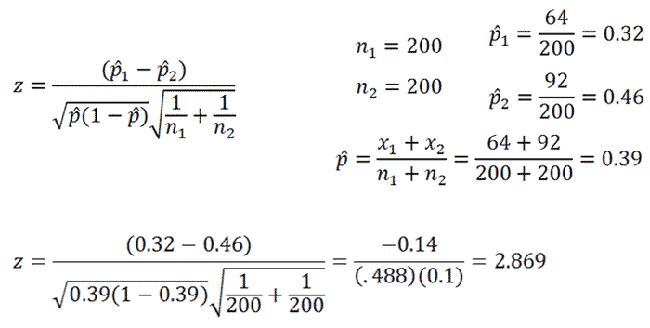

In [19]:
control_sample_size,treatment_sample_size=len(customer_data[customer_data.Treatment==0]), len(customer_data[customer_data.Treatment==1])
control_sample_size,treatment_sample_size

(35972, 36028)

In [21]:
control_success_size = len(customer_data[(customer_data.Treatment==0) & (customer_data['Event Length']==6)])
treatment_success_size = len(customer_data[(customer_data.Treatment==1) & (customer_data['Event Length']==6)])

In [22]:
control_success_rate=control_success_size/control_sample_size
control_success_rate

0.034026465028355386

In [23]:
treatment_success_rate=treatment_success_size/treatment_sample_size
treatment_success_rate

0.30520706117464197

In [26]:
p_hat = (control_success_size + treatment_success_size) / (control_sample_size + treatment_sample_size)
p_hat

0.16972222222222222

- Check if the sample size is large enough to use the normal approximation

In [32]:
#check normality, sufficient sample size
assert treatment_sample_size*treatment_success_rate>=5
assert treatment_sample_size*(1-treatment_success_rate)>=5
assert control_sample_size*control_success_rate>=5
assert control_sample_size*(1-control_success_rate)>=5

In [28]:
z_stat = (treatment_success_rate - control_success_rate) / math.sqrt(p_hat * (1 - p_hat) * (1/control_sample_size + 1/treatment_sample_size))
z_stat

96.9200591337484

- The Z-statistic is clearly much larger than 1.96, 3, or anything else reasonable.  Statistically significant result!  See below, p-val is close to zero.

In [34]:
p_value = 2 * (1 - norm.cdf(abs(z_stat)))
p_value

0.0

## Without normality assumption, can use chi2

In [35]:
from scipy.stats import chi2_contingency

In [36]:
customer_data['Reached_Last_Stage']=customer_data['Event Length']==6

In [37]:
customer_data.Reached_Last_Stage.value_counts()

False    59780
True     12220
Name: Reached_Last_Stage, dtype: int64

In [39]:
treatment_group = customer_data[customer_data.Treatment==1]
control_group = customer_data[customer_data.Treatment==0]
treatment_reached =treatment_group['Reached_Last_Stage'].sum()
treatment_total=len(treatment_group)
control_reached =control_group['Reached_Last_Stage'].sum()
control_total=len(control_group)

contingency_table = np.array([[treatment_reached, treatment_total-treatment_reached], [control_reached, control_total-control_reached]])
chi2_contingency, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi2: {chi2_contingency}, p-value: {p}')


Chi2: 9391.573556002735, p-value: 0.0


- Again, p-value rounds down to zero due to floating point precision. This means that we can reject the null hypothesis and conclude that the treatment group has a higher conversion rate than the control group.